In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
import tensorflow.keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os

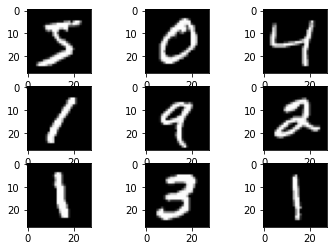

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [ ]:
from matplotlib import pyplot
for i in range(9):  
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(x_train_org[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

print('X_train: ' + str(x_train_org.shape))
print('Y_train: ' + str(y_train_org.shape))
print('X_test:  '  + str(x_test_org.shape))
print('Y_test:  '  + str(y_test_org.shape))

In [85]:
def make_pairs(images, labels):
	  # initialize two empty lists to hold the (image, image) pairs and
	  # labels to indicate if a pair is positive or negative
    pairImages = []
    pairLabels = []
	  # calculate the total number of classes present in the dataset
	  # and then build a list of indexes for each class label that
	  # provides the indexes for all examples with a given label
    numClasses = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in [range(0, numClasses)]]
	  # loop over all images
    for idxA in range(len(images)):
		    # grab the current image and label belonging to the current
		    # iteration
        currentImage = images[idxA]
        label = labels[idxA]
		    # randomly pick an image that belongs to the *same* class
		    # label
        idxB = np.random.choice(idx[label])
        posImage = images[idxB]
		    # prepare a positive pair and update the images and labels
		    # lists, respectively
        pairImages.append([currentImage, posImage])
        pairLabels.append([1])
		    # grab the indices for each of the class labels *not* equal to
		    # the current label and randomly pick an image corresponding
		    # to a label *not* equal to the current label
        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]
		    # prepare a negative pair of images and update our lists
        pairImages.append([currentImage, negImage])
        pairLabels.append([0])
	# return a 2-tuple of our image pairs and labels
    return (np.array(pairImages), np.array(pairLabels))

In [2]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [ ]:
def build_siamese_model(inputShape, embeddingDim=48):
	# specify the inputs for the feature extractor network
    inputs = Input(inputShape)
    	# define the first set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    	# second set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
      
    	# prepare the final outputs
    pooledOutput = GlobalAveragePooling2D()(x)
    x = Dense(embeddingDim)(pooledOutput)
    outputs = Dense(2)(x)
    	# build the model
    model = Model(inputs, outputs)
    	# return the model to the calling function
    return model

 Here we define the **Contrastice Loss** for the model which consist of two parts as below:
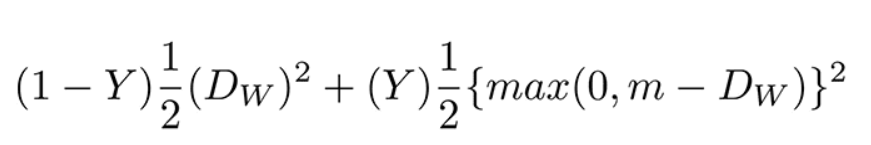

The first term is for pairs which are considered similar and second term corresponds to dissimilar pairs used for training.

In [120]:

def contrastive_loss(y, preds, margin=0.75):
	# explicitly cast the true class label data type to the predicted
	# class label data type (otherwise we run the risk of having two
	# separate data types, causing TensorFlow to error out)
	y = tf.cast(y, preds.dtype)
	# calculate the contrastive loss between the true labels and
	# the predicted labels
	squaredPreds = K.square(preds)
	squaredMargin = K.square(K.maximum(margin - preds, 0))
	loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
	# return the computed contrastive loss to the calling function
	return loss

In [115]:

def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.title("Training Loss")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)
	plt.show()

In [43]:
def plot_DR(x,y,ni=[0,1,2,3,4,5,6,7,8,9],layer_name='dense',title='Train data Dimensionality Reduction'):
    indexes=[np.where(y == i)[0] for i in ni]
    keras_function = K.function([featureExtractor.input], [featureExtractor.get_layer(layer_name).output])
    #plt.figure(figsize=(9,6))
    colors = ['#66CDAA', '#0000FF', '#CD3333', '#FF6103', '#EEEE00', '#D02090', '#8B5A2B', '#4682B4', '#6A5ACD', '#282828']
    x1=[]
    for i in range(len(ni)):
        x1.append(x[indexes[i],:,:])
        outputs=(keras_function(x1[i]))
        plt.scatter(outputs[0][:,0],outputs[0][:,1],s=2,label=ni[i])
    plt.legend()  
    plt.show()

In [ ]:
# load MNIST dataset and scale the pixel values to the range of [0, 1]
print("[INFO] loading MNIST dataset...")
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
# add a channel dimension to the images
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
# prepare the positive and negative pairs
print("[INFO] preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs(x_train, y_train)
(pairTest, labelTest) = make_pairs(x_test, y_test)

[INFO] loading MNIST dataset...
11501568/11490434 [==============================] - 0s 0us/step
[INFO] preparing positive and negative pairs...


In [ ]:
# import the necessary packages
import os
# specify the shape of the inputs for our network
IMG_SHAPE = (28, 28, 1)
# specify the batch size and number of epochs
BATCH_SIZE = 64
EPOCHS = 10
# define the path to the base output directory
BASE_OUTPUT = "output"
# use the base output path to derive the path to the serialized
# model along with training history plot
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

In [ ]:
# configure the siamese network
print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)
# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
model = Model(inputs=[imgA, imgB], outputs=distance)

[INFO] building siamese network...


[INFO] compiling model...
[INFO] training model...
Epoch 1/10
1875/1875 [==============================] - 328s 175ms/step - loss: 0.1896 - val_loss: 0.1647
Epoch 2/10
1875/1875 [==============================] - 324s 173ms/step - loss: 0.1700 - val_loss: 0.1442
Epoch 3/10
1875/1875 [==============================] - 325s 173ms/step - loss: 0.1604 - val_loss: 0.1381
Epoch 4/10
1875/1875 [==============================] - 327s 174ms/step - loss: 0.1548 - val_loss: 0.1353
Epoch 5/10
1875/1875 [==============================] - 322s 172ms/step - loss: 0.1504 - val_loss: 0.1331
Epoch 6/10
1875/1875 [==============================] - 321s 171ms/step - loss: 0.1472 - val_loss: 0.1254
Epoch 7/10
1875/1875 [==============================] - 316s 168ms/step - loss: 0.1449 - val_loss: 0.1245
Epoch 8/10
1875/1875 [==============================] - 315s 168ms/step - loss: 0.1430 - val_loss: 0.1203
Epoch 9/10
1875/1875 [==============================] - 315s 168ms/step - loss: 0.1411 - val_loss: 0.

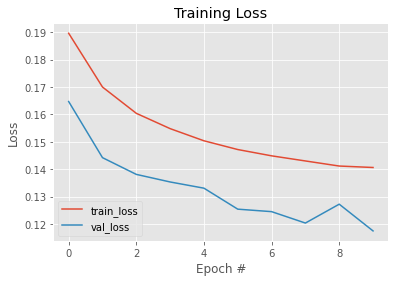

In [ ]:
# compile the model
print("[INFO] compiling model...")
model.compile(loss=contrastive_loss, optimizer="adam")
# train the model
print("[INFO] training model...")
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE,
	epochs=EPOCHS)
# serialize the model to disk
print("[INFO] saving siamese model...")
model.save(MODEL_PATH)
# plot the training history
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)

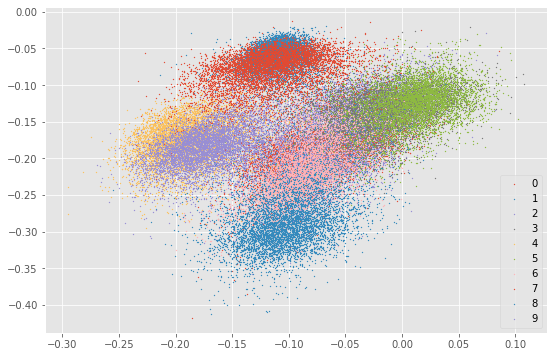

In [ ]:
plot_DR(x_train,y_train,ni=2,layer_name='dense',title='Train data Dimensionality Reduction')

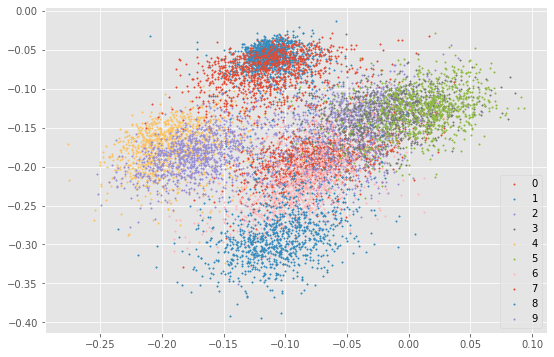

In [ ]:
plot_DR(x_test,y_test,ni=2,layer_name='dense',title='Test data Dimensionality Reduction')

 Function **make_pairs_knn** makes pairs as:
 * The 5 nearest neighbors of each sample as positive pair
 * 10 negative random pairs from farther points

This function has only applied for **"4"** and **"9"** digits.

In [78]:
# Finding the 5 nearest neighbors to each point (section 3.2)
from sklearn.neighbors import NearestNeighbors
def make_pairs_knn(x_t,labels,k):
  idx = [np.where(labels == i)[0] for i in [4,9]]
  idxA=[]
  indexes=np.zeros((2000))
  images=np.zeros((2000,32,32,1))
  for i in range(2):
    idxA.append(np.random.choice(idx[i],1000))
    indexes[i*1000:(i+1)*1000]=idxA[i]
    images[i*1000:(i+1)*1000]=x_t[idxA[i]]

  knn_input=images.copy()
  knn_input=knn_input.reshape((knn_input.shape[0], -1))
  KNN = NearestNeighbors(n_neighbors=k+1, p=2)
  pairs=np.zeros((2000,k+1))
  for i in range(2):
    KNN.fit(knn_input[i*1000:(i+1)*1000])
    pairs[i*1000:(i+1)*1000]=KNN.kneighbors(knn_input[i*1000:(i+1)*1000], return_distance=False)

  pairImages=[]
  pairLabels=[]
  for i in range(len(images)):
    # creating positive pairs
    for j in range(k):
        if not int(pairs[i][j])==i:
            pairImages.append([images[i],images[int(pairs[i][j])]])
            pairLabels.append(0)
    
    # creating negative pairs
    for m in range(10):
      rand=random.randint(0, 1999)
      if rand not in pairs[i]:
        pairImages.append([images[i],images[rand]])
        pairLabels.append(1)
      else:
        m-=1
  return (np.array(pairImages), np.array(pairLabels))

In [58]:
def build_siamese_model_knn(inputShape, embeddingDim=48):
	# specify the inputs for the feature extractor network
	inputs = Input(inputShape)
	# define the first set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(15, (6, 6), padding="valid")(inputs)
	x = MaxPooling2D(pool_size=(3, 3) , strides=(3,3))(x)

	# second set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(30, (9, 9), padding="valid")(x)
 
	# prepare the final outputs
	pooledOutput = GlobalAveragePooling2D()(x)
	outputs = Dense(2,name='output_layer')(pooledOutput)
	# build the model
	model = Model(inputs, outputs)
	# return the model to the calling function
	return model

In [9]:
def partitioning(x,y,n_instance=3000,list1=[]):
    z=0
    labels=np.zeros((n_instance*len(list1)))
    for i in list1:
        indx=np.where(y==i)[0]
        labels[z*n_instance:(z+1)*n_instance]=np.random.choice(indx,n_instance)
        z+=1
    labels=labels.astype(int)
    x_1=x[labels,:,:]
    y_1=y[labels]
    return x_1,y_1

In [142]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
print("[INFO] preparing positive and negative pairs...")
x_train=np.pad(x_train, ((0,0),(2,2),(2,2)))
x_test=np.pad(x_test, ((0,0),(2,2),(2,2)))

x_train_p,y_train_p=partitioning(x_train,y_train,list1=[4,9])
x_test_p,y_test_p=partitioning(x_test,y_test,n_instance=2000, list1=[4,9])

x_train_p = np.expand_dims(x_train_p, axis=-1)
x_test_p = np.expand_dims(x_test_p, axis=-1)

(pairTrain, labelTrain) = make_pairs_knn(x_train_p, y_train_p,5)
(pairTest, labelTest) = make_pairs_knn(x_test_p, y_test_p,5)

IMG_SHAPE = (32, 32, 1)
BATCH_SIZE = 500
EPOCHS = 1
BASE_OUTPUT = "output"
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

[INFO] preparing positive and negative pairs...


In [143]:
# configure the siamese network
print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model_knn(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)
distance = Lambda(euclidean_distance)([featsA, featsB])
model = Model(inputs=[imgA, imgB], outputs=distance)

# compile the model
print("[INFO] compiling model...")
model.compile(loss=contrastive_loss, optimizer="adam")
# train the model
print("[INFO] training model...")
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE,
	epochs=EPOCHS)
# serialize the model to disk
print("[INFO] saving siamese model...")
model.save(MODEL_PATH)
# plot the training history
print("[INFO] plotting training history...")


[INFO] building siamese network...
[INFO] compiling model...
[INFO] training model...
58/58 [==============================] - 35s 573ms/step - loss: 0.1367 - val_loss: 0.1424
[INFO] saving siamese model...
INFO:tensorflow:Assets written to: output/siamese_model/assets
[INFO] plotting training history...


[INFO] building siamese network...
[INFO] compiling model...
[INFO] training model...
Epoch 1/5
58/58 [==============================] - 31s 527ms/step - loss: 0.2437 - val_loss: 0.2511
Epoch 2/5
58/58 [==============================] - 31s 535ms/step - loss: 0.2310 - val_loss: 0.2496
Epoch 3/5
58/58 [==============================] - 43s 734ms/step - loss: 0.2255 - val_loss: 0.2504
Epoch 4/5
58/58 [==============================] - 37s 638ms/step - loss: 0.2215 - val_loss: 0.2495
Epoch 5/5
58/58 [==============================] - 29s 495ms/step - loss: 0.2189 - val_loss: 0.2526
[INFO] saving siamese model...
INFO:tensorflow:Assets written to: output/siamese_model/assets
[INFO] plotting training history...


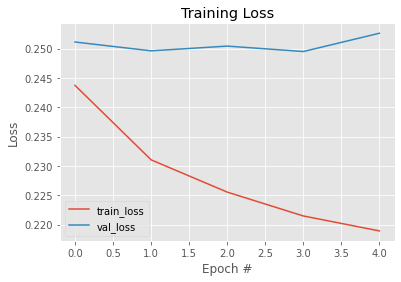

In [96]:
# configure the siamese network
print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model_knn(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)
distance = Lambda(euclidean_distance)([featsA, featsB])
model = Model(inputs=[imgA, imgB], outputs=distance)

# compile the model
print("[INFO] compiling model...")
model.compile(loss=contrastive_loss, optimizer="adam")
# train the model
print("[INFO] training model...")
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE,
	epochs=EPOCHS)
# serialize the model to disk
print("[INFO] saving siamese model...")
model.save(MODEL_PATH)
# plot the training history
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)

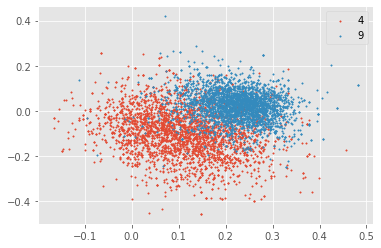

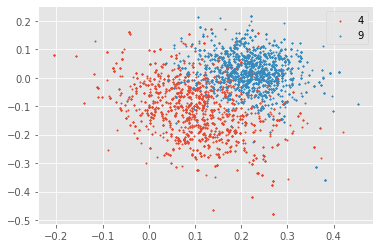

In [122]:
plot_DR(x_train_p,y_train_p,ni=[4,9],layer_name='output_layer',title='Train data Dimensionality Reduction')
plot_DR(x_test_p,y_test_p,ni=[4,9],layer_name='output_layer',title='Test data Dimensionality Reduction')

Studying effect of **margin**

[INFO] preparing positive and negative pairs...
[INFO] building siamese network...
Epoch 1/5
58/58 [==============================] - 31s 517ms/step - loss: 0.0032 - val_loss: 7.4693e-04
Epoch 2/5
58/58 [==============================] - 30s 513ms/step - loss: 2.7937e-04 - val_loss: 4.2692e-04
Epoch 3/5
58/58 [==============================] - 30s 511ms/step - loss: 1.3837e-04 - val_loss: 2.9747e-04
Epoch 4/5
58/58 [==============================] - 30s 527ms/step - loss: 8.7061e-05 - val_loss: 2.4178e-04
Epoch 5/5
58/58 [==============================] - 32s 550ms/step - loss: 6.2429e-05 - val_loss: 1.9339e-04


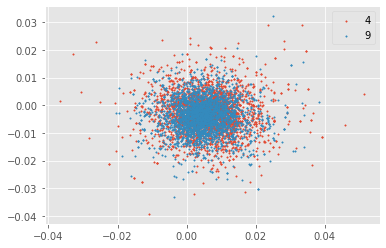

Epoch 1/5
58/58 [==============================] - 31s 517ms/step - loss: 0.0105 - val_loss: 0.0106
Epoch 2/5
58/58 [==============================] - 29s 511ms/step - loss: 0.0093 - val_loss: 0.0105
Epoch 3/5
58/58 [==============================] - 29s 511ms/step - loss: 0.0090 - val_loss: 0.0105
Epoch 4/5
58/58 [==============================] - 29s 511ms/step - loss: 0.0088 - val_loss: 0.0105
Epoch 5/5
58/58 [==============================] - 30s 512ms/step - loss: 0.0087 - val_loss: 0.0104


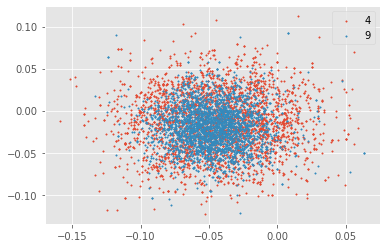

Epoch 1/5
58/58 [==============================] - 31s 518ms/step - loss: 0.0617 - val_loss: 0.0634
Epoch 2/5
58/58 [==============================] - 30s 512ms/step - loss: 0.0574 - val_loss: 0.0629
Epoch 3/5
58/58 [==============================] - 30s 513ms/step - loss: 0.0557 - val_loss: 0.0637
Epoch 4/5
58/58 [==============================] - 30s 513ms/step - loss: 0.0547 - val_loss: 0.0637
Epoch 5/5
58/58 [==============================] - 30s 512ms/step - loss: 0.0542 - val_loss: 0.0637


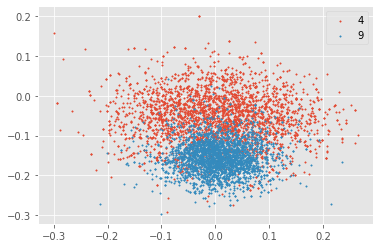

Epoch 1/5
58/58 [==============================] - 30s 510ms/step - loss: 0.1374 - val_loss: 0.1429
Epoch 2/5
58/58 [==============================] - 28s 493ms/step - loss: 0.1291 - val_loss: 0.1431
Epoch 3/5
58/58 [==============================] - 29s 495ms/step - loss: 0.1264 - val_loss: 0.1438
Epoch 4/5
58/58 [==============================] - 29s 495ms/step - loss: 0.1237 - val_loss: 0.1451
Epoch 5/5
58/58 [==============================] - 31s 538ms/step - loss: 0.1220 - val_loss: 0.1448


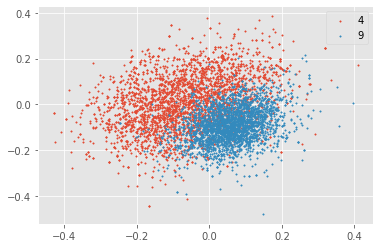

Epoch 1/5
58/58 [==============================] - 30s 502ms/step - loss: 0.2452 - val_loss: 0.2505
Epoch 2/5
58/58 [==============================] - 29s 496ms/step - loss: 0.2316 - val_loss: 0.2497
Epoch 3/5
58/58 [==============================] - 29s 495ms/step - loss: 0.2260 - val_loss: 0.2504
Epoch 4/5
58/58 [==============================] - 29s 496ms/step - loss: 0.2234 - val_loss: 0.2528
Epoch 5/5
58/58 [==============================] - 29s 495ms/step - loss: 0.2190 - val_loss: 0.2545


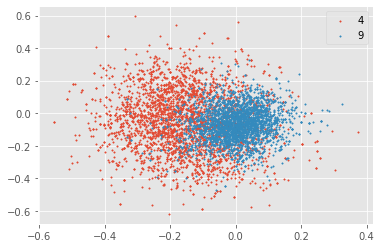

In [119]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
print("[INFO] preparing positive and negative pairs...")
x_train=np.pad(x_train, ((0,0),(2,2),(2,2)))
x_test=np.pad(x_test, ((0,0),(2,2),(2,2)))

x_train_p,y_train_p=partitioning(x_train,y_train,list1=[4,9])
x_test_p,y_test_p=partitioning(x_test,y_test,n_instance=2000, list1=[4,9])

x_train_p = np.expand_dims(x_train_p, axis=-1)
x_test_p = np.expand_dims(x_test_p, axis=-1)

(pairTrain, labelTrain) = make_pairs_knn(x_train_p, y_train_p,5)
(pairTest, labelTest) = make_pairs_knn(x_test_p, y_test_p,5)
class conloss:
  def __init__(self,margin=1):
    self.margin=margin
  def contrastive_loss(self,y, preds):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(self.margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss
IMG_SHAPE = (32, 32, 1)
BATCH_SIZE = 500
EPOCHS = 5
BASE_OUTPUT = "output"
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
# configure the siamese network
print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
loss1=[]
for i in [0.01,0.2,0.5,0.75,1]:
  featureExtractor = build_siamese_model_knn(IMG_SHAPE)
  featsA = featureExtractor(imgA)
  featsB = featureExtractor(imgB)
  distance = Lambda(euclidean_distance)([featsA, featsB])
  model = Model(inputs=[imgA, imgB], outputs=distance)

# compile the model
  objloss=conloss(margin=i)
  contrloss=objloss.contrastive_loss
  model.compile(loss=contrloss, optimizer="adam")
# train the model
  history = model.fit(
	  [pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	  validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	  batch_size=BATCH_SIZE,
	  epochs=EPOCHS)
  loss1.append(history.history["loss"][0])
  plot_DR(x_train_p,y_train_p,ni=[4,9],layer_name='output_layer',title='Train data Dimensionality Reduction')

In [ ]:
plt.plot([0.5,1,2,3],loss1)
plt.show()

In [47]:
def distortion(x,y):
  t=x.shape[0]
  x_new=np.zeros((t*5,32,32))
  x_new[0:t]=x[:]
  y_new=np.zeros((t*5))
  y_new[0:t]=y[:]
  for w,i in enumerate([-6,-3,3,6]):
      x_new[(w+1)*t:(w+2)*t]=np.roll(x,i)
      y_new[(w+1)*t:(w+2)*t]=y[:]
  return x_new,y_new

In [98]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
print("[INFO] preparing positive and negative pairs...")
x_train=np.pad(x_train, ((0,0),(2,2),(2,2)))
x_test=np.pad(x_test, ((0,0),(2,2),(2,2)))

x_train_p,y_train_p=partitioning(x_train,y_train,n_instance=500,list1=[4,9])
x_test_p,y_test_p=partitioning(x_test,y_test,n_instance=500, list1=[4,9])

x_train_p3,y_train_p3=distortion(x_train_p,y_train_p)
x_test_p3,y_test_p3=distortion(x_test_p,y_test_p)

x_train_p3 = np.expand_dims(x_train_p3, axis=-1)
x_test_p3 = np.expand_dims(x_test_p3, axis=-1)
(pairTrain, labelTrain) = make_pairs_knn(x_train_p3, y_train_p3,5)
(pairTest, labelTest) = make_pairs_knn(x_test_p3, y_test_p3,5)

[INFO] preparing positive and negative pairs...


In [103]:
IMG_SHAPE = (32, 32, 1)
BATCH_SIZE = 500
EPOCHS = 1
BASE_OUTPUT = "output"
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

# configure the siamese network
print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model_knn(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)
distance = Lambda(euclidean_distance)([featsA, featsB])
model = Model(inputs=[imgA, imgB], outputs=distance)

# compile the model
print("[INFO] compiling model...")
model.compile(loss=contrastive_loss, optimizer="adam")
# train the model
print("[INFO] training model...")
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE,
	epochs=EPOCHS)
# serialize the model to disk
print("[INFO] saving siamese model...")
model.save(MODEL_PATH)


[INFO] building siamese network...
[INFO] compiling model...
[INFO] training model...
58/58 [==============================] - 32s 536ms/step - loss: 0.2466 - val_loss: 0.2466
[INFO] saving siamese model...
INFO:tensorflow:Assets written to: output/siamese_model/assets


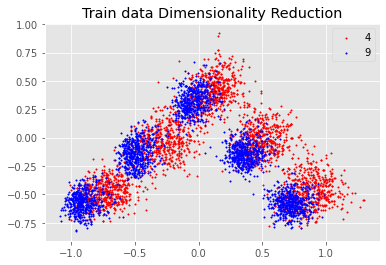

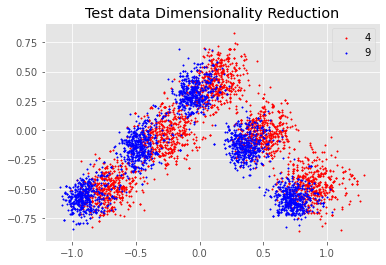

In [104]:
def plot_DR_p3(x,y,ni=[0,1,2,3,4,5,6,7,8,9],layer_name='dense',title='Train data Dimensionality Reduction'):
    indexes=[np.where(y == i)[0] for i in ni]
    keras_function = K.function([featureExtractor.input], [featureExtractor.get_layer(layer_name).output])
    colors = ['#FF0000', '#0000FF']
    x1=[]
    k=0
    outs_f=np.zeros((x.shape[0],2))
    for i in range(len(ni)):
        outs_f=np.zeros((2500,2))
        for j,w in enumerate([0,-0.8,-0.4,0.4,0.8]):
            x1.append(x[indexes[i][j*500:(j+1)*500],:,:])
            outputs=(keras_function(x1[k]))
            outputs[0][:,0]-=w
            outputs[0][:,1]-=abs(w)
            outs_f[j*500:(j+1)*500]=outputs[0]
            k+=1
        plt.scatter(outs_f[:,0],outs_f[:,1],s=2,c=colors[i])
    plt.title(title)
    plt.legend(['4','9'])  
    plt.show()
    return 

plot_DR_p3(x_train_p3,y_train_p3,ni=[4,9],layer_name='output_layer',title='Train data Dimensionality Reduction')
plot_DR_p3(x_test_p3,y_test_p3,ni=[4,9],layer_name='output_layer',title='Test data Dimensionality Reduction')

[INFO] preparing positive and negative pairs...


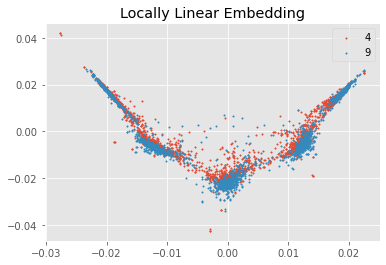

In [70]:
from sklearn.manifold import LocallyLinearEmbedding
from matplotlib import offsetbox
from sklearn.preprocessing import MinMaxScaler

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
print("[INFO] preparing positive and negative pairs...")
x_train=np.pad(x_train, ((0,0),(2,2),(2,2)))
x_test=np.pad(x_test, ((0,0),(2,2),(2,2)))

x_train_p,y_train_p=partitioning(x_train,y_train,n_instance=500,list1=[4,9])
x_test_p,y_test_p=partitioning(x_test,y_test,n_instance=500, list1=[4,9])

x_train_p3,y_train_p3=distortion(x_train_p,y_train_p)
x_test_p3,y_test_p3=distortion(x_test_p,y_test_p)

x_emb=x_train_p3.reshape((x_train_p3.shape[0], -1))
embedding = LocallyLinearEmbedding(n_neighbors=30, n_components=2, method="standard")

X = embedding.fit_transform(x_emb,y_train_p3)
def plot_embedding(X,y, title):
    #X = MinMaxScaler().fit_transform(X)
    for digit in [4,9]:
        a=X[y==digit]
        plt.scatter(a[:,0],a[:,1], s=2, label=digit)
    plt.title(title)
    plt.legend()
    plt.show()

plot_embedding(X, y_train_p3, "Locally Linear Embedding")

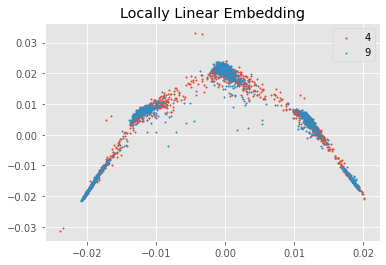

In [132]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

x_train=np.pad(x_train, ((0,0),(2,2),(2,2)))
x_test=np.pad(x_test, ((0,0),(2,2),(2,2)))

x_train_p,y_train_p=partitioning(x_train,y_train,n_instance=500,list1=[4,9])
x_test_p,y_test_p=partitioning(x_test,y_test,n_instance=500, list1=[4,9])

x_train_p3,y_train_p3=distortion(x_train_p,y_train_p)
x_test_p3,y_test_p3=distortion(x_test_p,y_test_p)

x_emb=x_train_p3.reshape((x_train_p3.shape[0], -1))
embedding = LocallyLinearEmbedding(n_neighbors=30, n_components=2, method="modified")

X = embedding.fit_transform(x_emb,y_train_p3)
def plot_embedding(X,y, title):
    #X = MinMaxScaler().fit_transform(X)
    for digit in [4,9]:
        a=X[y==digit]
        plt.scatter(a[:,0],a[:,1], s=2, label=digit)
    plt.title(title)
    plt.legend()
    plt.show()

plot_embedding(X, y_train_p3, "Locally Linear Embedding")